In [14]:
import pydrake

# 初始值

如果 drake 说一个优化问题没有解，该怎么调试呢？首先，明确该优化问题是否是凸的，对于凸问题（如 LP、QP、SDP），当问题有解时，理论上求解器一定能找到最优解；另一方面，如果问题是非凸的，而且选的是基于梯度的求解器（如 SNOPT / IPOPT），则即使存在最优解，求解器也可能陷入局部最优。一种可能的解决方案是选择不同初始值。

Starting from x=[0, 0], the solver result is SolutionResult.kInfeasibleConstraints
The solver gets stuck at x=[0. 0.]
Starting from x=[0.1, 0.5], the solver result is SolutionResult.kSolutionFound
The found solution is x=[0.01022453 1.08219118]


/tmp/ipykernel_77461/3235346447.py:28: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


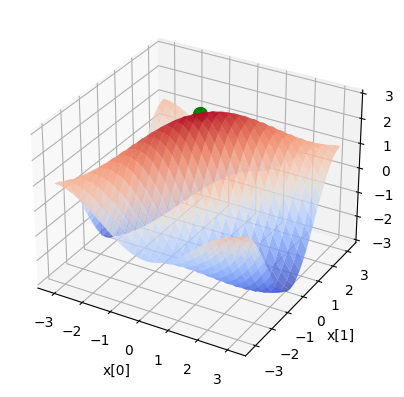

In [15]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from pydrake.solvers import MathematicalProgram, IpoptSolver
import numpy as np


def constraint(x):
    return [np.cos(x[0]) + 2 * np.cos(x[0] - x[1])]


# # 1 <= cos(x[0]) + 2 * cos(x[0] - x[1]) <= 2
# 这个问题有很多解, 比如 x = [0, pi/2]


def draw_constraint_landscape():
    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    x_mesh, y_mesh = np.meshgrid(
        np.linspace(-np.pi, np.pi, 31), np.linspace(-np.pi, np.pi, 31)
    )
    constraint_val = np.cos(x_mesh) + 2 * np.cos(x_mesh - y_mesh)
    surf = ax.plot_surface(x_mesh, y_mesh, constraint_val, cmap=cm.coolwarm, alpha=0.8)
    ax.plot([0], [0], [3], marker=".", color="g", markersize=20)
    ax.set_xlabel("x[0]")
    ax.set_ylabel("x[1]")
    ax.set_zlabel("cos(x[0]) + 2 * cos(x[0]-x[1])")
    fig.show()


draw_constraint_landscape()

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

prog.AddConstraint(constraint, [1], [2], x)

solver = IpoptSolver()
# With the initial guess being (0, 0), the solver cannot find a solution.
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print(f"Starting from x=[0, 0], the solver result is {result.get_solution_result()}")
print(f"The solver gets stuck at x={result.GetSolution(x)}")

# With a different initial guess, the solver can find the solution
prog.SetInitialGuess(x, [0.1, 0.5])
result = solver.Solve(prog)
print(
    f"Starting from x=[0.1, 0.5], the solver result is {result.get_solution_result()}"
)
print(f"The found solution is x={result.GetSolution(x)}")



如果初始猜测 $ x=\left[0, 0\right] $ ，求解器会卡住，因为约束函数 $\cos(x[0])+2\cos(x[0])$ 在 $ x=\left[0, 0\right] $ 的梯度为零，因此基于梯度的求解器不知道如何迭代决策变量。注意，即使求解器（如 SNOPT）在优化过程中找到了可行解，它也可能在下一次迭代中跳到不可行的解。有时，由于约束施加不正确，问题不可行。为了了解优化失败的原因，drake 提供了一些调试工具

# print(MathematicalProgram)

输出所有决策变量、代价函数和约束。

In [16]:
# A sample (quadratic) program
prog = MathematicalProgram()
x = prog.NewContinuousVariables(3, "x")
prog.AddQuadraticCost(x[0] * x[0] + 2 * x[0] + 3)
prog.Add2NormSquaredCost(A = [[1, 3], [2, 4]], b=[1, 4], vars=[x[1], x[2]])
prog.AddLinearEqualityConstraint(x[0] + 2*x[1] == 5)
prog.AddLinearConstraint(x[0] + 4 *x[1] <= 10)
prog.AddBoundingBoxConstraint(-1, 10, x)

# Now print a summary:
print(prog)

Decision variables:x(0) x(1) x(2)

QuadraticCost (3 + 2 * x(0) + pow(x(0), 2))
QuadraticCost (17 - 18 * x(1) - 38 * x(2) + (x(1) * (5 * x(1) + 11 * x(2))) + (x(2) * (11 * x(1) + 25 * x(2))))
LinearConstraint
-inf <= (x(0) + 4 * x(1)) <= 10
LinearEqualityConstraint
(x(0) + 2 * x(1)) == 5
BoundingBoxConstraint
-1 <= x(0) <= 10
-1 <= x(1) <= 10
-1 <= x(2) <= 10



# 给决策变量，代价函数和约束条件命名

## 决策变量

In [17]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
print(x)

[Variable('point(0)', Continuous) Variable('point(1)', Continuous)]


## 约束条件

In [18]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
constraint = prog.AddConstraint(lambda z: [np.sum(z**2)], [1.], [1.], x)
constraint.evaluator().set_description("unit-length constraint")
print(constraint)

PyFunctionConstraint described as 'unit-length constraint' with 2 decision variables point(0) point(1)



## 代价函数

In [19]:
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "point")
# Add the cost on the distance to (1, 2)
cost1 = prog.AddCost(lambda z: np.sqrt((z[0]-1)**2 + (z[1]-2)**2), x)
cost1.evaluator().set_description("distance to (1, 2)")
# Add the cost on the distance to (3, -1)
cost2 = prog.AddCost(lambda z: np.sqrt((z[0]-3)**2 + (z[1] + 1)**2), x)
cost2.evaluator().set_description("distance to (3, -1)")
print(f"cost1: {cost1}")
print(f"cost2: {cost2}")

cost1: PyFunctionCost described as 'distance to (1, 2)' with 2 decision variables point(0) point(1)

cost2: PyFunctionCost described as 'distance to (3, -1)' with 2 decision variables point(0) point(1)



# 找到问题之所在：`GetInfeasibleConstraints()`

当 MathematicalProgram 使用基于梯度的求解器（如 SNOPT / IPOPT）并报告问题没有可行解的时候，可以调用 [MathematicalProgramResult::GetInfeasibleConstraints()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraints) 或 [MathematicalProgramResult::GetInfeasibleConstraintNames()](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.MathematicalProgramResult.GetInfeasibleConstraintNames) 来检查有较大冲突的约束。然后可以修改的不可行约束，并相应地改进初始值。

In [20]:
import numpy as np
from pydrake.autodiffutils import InitializeAutoDiff, ExtractGradient

prog = MathematicalProgram()
x = prog.NewContinuousVariables(2, "x")

# Add the constraint dist(x, 0) >= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [1], [np.inf], x)
constraint1.evaluator().set_description("outside unit circle")

# Add the constraint x[0]**2 + 4 * x[1]**2 <= 4
constraint2 = prog.AddConstraint(lambda z: [z[0]**2 + 4 * z[1]**2], [0], [4], x)
constraint2.evaluator().set_description("inside ellipsoid 1")

solver = IpoptSolver()
prog.SetInitialGuess(x, [0, 0])
result = solver.Solve(prog)
print("Start from initial guess x = [0, 0]")
print(f"optimization status: {result.get_solution_result()}")
print(f"optimization status: {result.get_solution_result()}")
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")
x_stuck = result.GetSolution(x)
print(f"x_stuck={x_stuck.T}")
# Now evaluate the gradient of the constraint at x_stuck (where the solver gets stuck)
print(f"Gradient of the infeasible constraint at x_stuck: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_stuck)))}")

# For a different initial state, the constraint that was infeasible now has non-zero gradient
x_new = np.array([0.1, 0.2])
print(f"\nStart from initial guess x_new = {x_new}")
print(f"Gradient of the infeasible constraint at x_new: {ExtractGradient(infeasible_constraints[0].evaluator().Eval(InitializeAutoDiff(x_new)))}")
prog.SetInitialGuess(x, x_new)
# With this new initial guess, the solver will be able to find the solution
result = solver.Solve(prog)
print(f"optimization status: {result.get_solution_result()}")

Start from initial guess x = [0, 0]
optimization status: SolutionResult.kInfeasibleConstraints
optimization status: SolutionResult.kInfeasibleConstraints
infeasible constraint: PyFunctionConstraint described as 'outside unit circle' with 2 decision variables x(0) x(1)

x_stuck=[0. 0.]
Gradient of the infeasible constraint at x_stuck: [[0. 0.]]

Start from initial guess x_new = [0.1 0.2]
Gradient of the infeasible constraint at x_new: [[0.2 0.4]]
optimization status: SolutionResult.kSolutionFound


# 打印求解器详细信息

许多求解器可以打印每次迭代的信息，在 [SolverOptions](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.SolverOptions) 中启用 [kPrintToConsole](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption)  或 [kPrintFileName](https://drake.mit.edu/pydrake/pydrake.solvers.html#pydrake.solvers.CommonSolverOption) 。

请注意，在 Jupyter 中运行代码时，信息会打印到启动 Jupyter 的终端中，而不是 cell 里面。对于在线 Jupyter（如 Deepnote，CoLab），这意味着控制台输出将不可见。在这种情况下，打印到文件更好。

In [21]:
from pydrake.solvers import CommonSolverOption, SolverOptions

#  constraint: 1 <= squared_norm(x) <= 2.
#  constraint: 2 <= x[0]**2 + 4 * x[0]*x[1] + 4*x[1]**2 + 2 * x[0] <= 5.
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(lambda z: [z.dot(z)], [1], [2], x)
prog.AddConstraint(lambda z: [z[0] ** 2 + 4 * z[0] * z[1] + 4 * z[1]**2 + 2 * z[0]], [2], [5], x)
prog.SetInitialGuess(x, [0, 0])

# Solve with printing.
ipopt_solver = IpoptSolver()
filename = "debug.txt"
solver_options = SolverOptions()
solver_options.SetOption(CommonSolverOption.kPrintFileName, filename)
result = ipopt_solver.Solve(prog, solver_options=solver_options)
with open(filename) as f:
    print(f.read())

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0


Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:   0.0000000000000000e+00    0.0000000000000000e+00
Dual infeasibility......:   3.7006228269558436e-11    3.7006228269558436e-11
Constraint violation....:   0.0000000000000000e+00    0.0000000000000000e+00
Complementarity.........:   1.0080321436543617e-11    1.0080321436543617e-11
Overall NLP er

一些求解器还提供了日志等级的选项。如 [IPOPT](https://coin-or.github.io/Ipopt/OPTIONS.html) 为终端打印日志提供的 `print_level`，为文件输出提供 `file_print_level`。

In [22]:
# Enable a slightly more verbose level of printing this time.
# The options can be attached to the program, instead of passed to Solve().
solver_options.SetOption(IpoptSolver.id(), "print_level", 5)
prog.SetSolverOptions(solver_options)
result = ipopt_solver.Solve(prog)

This is Ipopt version 3.11.9, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        4
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        2
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        2
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        2
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

# 回调函数

之前说过了

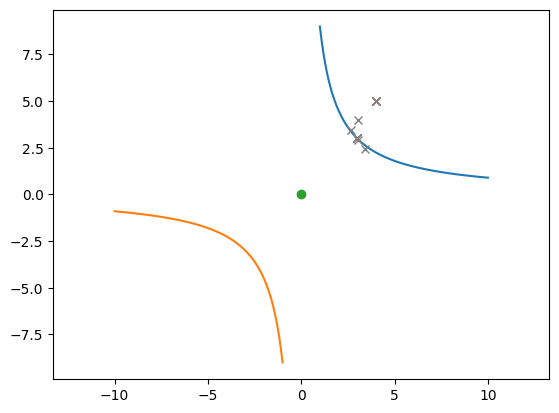

In [23]:
from pydrake.solvers import Solve

fig = plt.figure()
curve_x = np.linspace(1, 10, 100)
ax = plt.gca()
ax.plot(curve_x, 9./curve_x)
ax.plot(-curve_x, -9./curve_x)
ax.plot(0, 0, 'o')
x_init = [4., 5.]
ax.plot(x_init[0], x_init[1], 'x')
ax.axis('equal')

def visualization_callback(x):
    ax.plot(x[0], x[1], 'x', color='gray')
    
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)
prog.AddConstraint(x[0] * x[1] == 9)
prog.AddCost(x[0]**2 + x[1]**2)
prog.AddVisualizationCallback(visualization_callback, x)
result = Solve(prog, x_init)

# EvalBinding

就是将符号变量带入数值计算表达式的值

In [24]:
## Demonstrate EvalBinding function
prog = MathematicalProgram()
p1 = prog.NewContinuousVariables(2, "p1")
p2 = prog.NewContinuousVariables(2, "p2")

# Add the constraint that p1 is in an ellipsoid (p1(0)-1)**2 + 4*(p1(1)-2)**2 <= 1
constraint1 = prog.AddConstraint(lambda z: [(z[0]-1)**2 + 4 * (z[1]-2)**2], [0], [1], p1)
# Add the constraint that p2 is in an ellipsoid (p2(0) + 2)**2 + 0.25*(p2(1)+ 1)**2) <= 1
constraint2 = prog.AddConstraint(lambda z: [(z[0]+2)**2 + 0.25*(z[1]+1)**2], [0], [1], p2)
# Add a cost to minimize the distance between p1 and p2
cost = prog.AddCost((p1-p2).dot(p1-p2))

# Evaluate the constraint and cost at a guess p1=[0, 1], p2 = [-1, -4]
p1_val = [0, 1]
p2_val = [-1, -4]
prog.SetInitialGuess(p1, p1_val)
prog.SetInitialGuess(p2, p2_val)
print(f"constraint 1 evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(constraint1, prog.initial_guess())}")
print(f"constraint 2 evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(constraint2, prog.initial_guess())}")
print(f"cost evaluated at p1={p1_val}, p2={p2_val} is {prog.EvalBinding(cost, prog.initial_guess())}")


constraint 1 evaluated at p1=[0, 1], p2=[-1, -4] is [5.]
constraint 2 evaluated at p1=[0, 1], p2=[-1, -4] is [3.25]
cost evaluated at p1=[0, 1], p2=[-1, -4] is [26.]


# 减少（松弛）约束条件

In [25]:
# Relaxing the constraint
prog = MathematicalProgram()
x = prog.NewContinuousVariables(2)

# Add the constraint x^T * x <= 1
constraint1 = prog.AddConstraint(lambda z: [z.dot(z)], [0], [1], x)
constraint1.evaluator().set_description("inside unit circle")

# Add the constraint norm(x-[3, 0]) <= 1
constraint2 = prog.AddConstraint(lambda z: [np.sum((z - np.array([3, 0]))**2)], [0], [1], x)
constraint2.evaluator().set_description("distance to [3, 0] less than 1")

prog.SetInitialGuess(x, [1, 0])
solver = IpoptSolver()
result = solver.Solve(prog)
print(f"For the original problem, the solver status is {result.get_solution_result()}")
print(f"x is stuck at {result.GetSolution(x)}")
# Now get the infeasible constraint
infeasible_constraints = result.GetInfeasibleConstraints(prog)
for c in infeasible_constraints:
    print(f"infeasible constraint: {c}")

# Now update the upper bound of the first infeasible constraint
infeasible_constraints[0].evaluator().UpdateUpperBound([4])
# I also update the description of the constraint. Without updating the description, the
# problem still solves fine, but it would be confusing if you print out this constraint.
infeasible_constraints[0].evaluator().set_description("inside a circle with radius=2")
result = solver.Solve(prog)
print(f"For the relaxed problem, the solver status is {result.get_solution_result()}")
print(f"Solution is x = {result.GetSolution(x)}")

For the original problem, the solver status is SolutionResult.kInfeasibleConstraints
x is stuck at [1.5 0. ]
infeasible constraint: PyFunctionConstraint described as 'inside unit circle' with 2 decision variables x(0) x(1)

infeasible constraint: PyFunctionConstraint described as 'distance to [3, 0] less than 1' with 2 decision variables x(0) x(1)

For the relaxed problem, the solver status is SolutionResult.kSolutionFound
Solution is x = [2. 0.]
